In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
from geopy.distance import vincenty
import numpy as np

########
# To use this notebook you have to change the data path with the one you have your own 'listings.csv'
data_path = '/content/drive/MyDrive/Data_Masterclass/project/data/' 
########

pd.options.mode.chained_assignment = None

## Preprocess data

In [3]:
def remove_outliers(df,cols, q1, q3):
    '''
    Function that removes the outliers of a set
    
    Inputs:
    - df: dataframe of the data
    - cols: The coloumns for wich the outliers need to be removed
    - q1: below whitc quantile to drop
    - q3: above which quantile to keep
    
    Output:
    The dataframe without the outliers
    '''
    
    Q1 = df[cols].quantile(q1)
    Q3 = df[cols].quantile(q3)
    IQR = Q3 - Q1

    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

In [4]:
def get_neigh_groupings(df):
    '''
    A function that creates the neighbourhood groupings based on the neighbourhood prices
    
    Input:
    df: The dataframe with the data. Needs to have a column named 'neighbourhood_clensed' and one named 'price'
    
    Output:
    A dictionary with keys all the neighbourhoods and value the group they belong
    '''
    groups_neigh = df.groupby('neighbourhood_cleansed').agg(np.mean)['price']
    groups_neigh = groups_neigh.sort_values()
    # groups_neigh

    groups_neigh.values
    groups_neigh_1 = groups_neigh[:6]
    groups_neigh_2 = groups_neigh[6:12]
    groups_neigh_3 = groups_neigh[12:18]
    groups_neigh_4 = groups_neigh[18:24]
    groups_neigh_5 = groups_neigh[24:30]
    groups_neigh_6 = groups_neigh[30:37]
    groups_neigh_7 = groups_neigh[37:44]

    d1 = dict.fromkeys(groups_neigh_1.index, '1')
    d2 = dict.fromkeys(groups_neigh_2.index, '2')
    d3 = dict.fromkeys(groups_neigh_3.index, '3')
    d4 = dict.fromkeys(groups_neigh_4.index, '4')
    d5 = dict.fromkeys(groups_neigh_5.index, '5')
    d6 = dict.fromkeys(groups_neigh_6.index, '6')
    d7 = dict.fromkeys(groups_neigh_7.index, '7')

    neigh_group = {**d1, **d2, **d3, **d4, **d5, **d6, **d7}
    return neigh_group


In [41]:
from numpy import inf

def missing_values_n_encoding(df, neigh_group):
    '''
    Function that fills missing values, encodes features and creates new features

    Inputs:
    - the dataframe and the neighbourhood grouping
    
    Outputs:
    The new dataframe without any missing valuees, encoded features and new features
    '''

    
    # Host feature handling
    df['host_is_superhost'] = df['host_is_superhost'].map({'t':1, 'f':0})
    df[['host_about', 'license']] = df[['host_about', 'license']].applymap(lambda x: 0 if pd.isnull(x) else 1)
    df['host_verifications'] = df['host_verifications'].apply(lambda row: len(row))
    df = df[~df['host_is_superhost'].isnull()]
    df['host_response_rate'] = df['host_response_rate'].str[:-1].astype('float64')
    df['host_response_rate'] = pd.cut(df['host_response_rate'], 
                                bins=[0, 50, 90, 99, 100], 
                                labels=['0-49%', '50-89%', '90-99%', '100%'], 
                                include_lowest=True)

    df['host_response_rate'] = df['host_response_rate'].astype('str')
    df['host_response_rate'] = df['host_response_rate'].replace('nan', 'unknown')
    df['host_response_time']= df['host_response_time'].fillna("unknown")


    # Listing features handling
    df['instant_bookable'] = df['instant_bookable'].map({'t':1, 'f':0})
    df['has_availability'] = df['has_availability'].map({'t':1, 'f':0})
    df['shared_bath'] = df['bathrooms_text'].apply(lambda s: 1 if 'shared' in str(s).split(' ') else 0) 
    df['bathrooms'] = df['bathrooms_text'].apply(lambda s: float(0.5) if 'half-bath' in str(s).lower() else float(str(s).split(' ')[0]))
    df['bathrooms'] = df['bathrooms'].fillna(0)


    # New features creation
    df['lat_center'] = 37.9715
    df['lon_center'] = 23.7257

    df['distance_parthenon'] = df.apply(lambda x: vincenty((x['latitude'], x['longitude']), (x['lat_center'], x['lon_center'])).km, axis = 1)
    df['amenities_number'] = df['amenities'].apply(lambda s: len(str(s)[1:].split(',')))
    df['neighbourhood_cleansed_group'] = df['neighbourhood_cleansed'].map(neigh_group)

    df = df.drop(columns=['lat_center','lon_center'])
    df = df.drop(columns=['bathrooms_text', 'amenities'])


    return df

In [6]:
def remove_outliers_per_room_type(df):
    '''
    Function that removes the outliers for the columns 'price', 'maximum_nights', 'minimum_nights' for each room type seperatetly

    Input:
    - Data frame to be processed

    Output:
    - The new dataframe without the outliers
    '''
    shared = remove_outliers(df[df['room_type']=='Shared room'], cols=['price', 'maximum_nights', 'minimum_nights'], q1=0.25, q3=0.75)
    priv = remove_outliers(df[df['room_type']=='Private room'], cols=['price', 'maximum_nights', 'minimum_nights'], q1=0.25, q3=0.75)
    hot = remove_outliers(df[df['room_type']=='Hotel room'],cols=['price', 'maximum_nights', 'minimum_nights'],q1=0.25, q3=0.75)
    home = remove_outliers(df[df['room_type']=='Entire home/apt'],cols=['price', 'maximum_nights', 'minimum_nights'],q1=0.25, q3=0.75)
    w_removed_out = pd.concat([shared,priv,hot,home], axis=0)
    
    return w_removed_out

In [7]:
def handle_amenities(df):
    '''
    Function that handles the 'amenities' feature. Checks if a list of amenities contains specific strings and if yes it puts a 1 in a new column

    Input:
    - The dataframe to be processed, needs to have a column named 'amenities'

    Output:
    A new dataframe with 26 new columns with boolean values for each type of amenity identified
    '''
    df.loc[df['amenities'].str.contains('kitchen', case=False), 'kitchen'] = 1
    df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning', case=False), 'air_conditioning'] = 1
    df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV', case=False), 'high_end_electronics'] = 1
    df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque', case=False), 'bbq'] = 1
    df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
    df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront', case=False), 'nature_and_views'] = 1
    df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
    df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
    df.loc[df['amenities'].str.contains('TV', case=False), 'tv'] = 1
    df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine', case=False), 'coffee_machine'] = 1
    df.loc[df['amenities'].str.contains('Cooking basics', case=False), 'cooking_basics'] = 1
    df.loc[df['amenities'].str.contains('Elevator', case=False), 'elevator'] = 1
    df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym', case=False), 'gym'] = 1
    df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children', case=False), 'child_friendly'] = 1
    df.loc[df['amenities'].str.contains('parking', case=False), 'parking'] = 1
    df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace', case=False), 'outdoor_space'] = 1
    df.loc[df['amenities'].str.contains('Host greets you', case=False), 'host_greeting'] = 1
    df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool', case=False), 'hot_tub_sauna_or_pool'] = 1
    df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi', case=False), 'internet'] = 1
    df.loc[df['amenities'].str.contains('Long term stays allowed', case=False), 'long_term_stays'] = 1
    df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)', case=False), 'pets_allowed'] = 1
    df.loc[df['amenities'].str.contains('Private entrance', case=False), 'private_entrance'] = 1
    df.loc[df['amenities'].str.contains('Safe|Security system', case=False), 'secure'] = 1
    df.loc[df['amenities'].str.contains('Self check-in', case=False), 'self_check_in'] = 1
    df.loc[df['amenities'].str.contains('Smoking allowed', case=False), 'smoking_allowed'] = 1
    df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible', case=False), 'accessible'] = 1
    df.loc[df['amenities'].str.contains('Suitable for events', case=False), 'event_suitable'] = 1   
    

    cols_to_replace_nulls = df.columns
    df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)
    df.drop(columns=['amenities'], axis=1, inplace=True)

    return df

In [8]:
def preprocess(df):
    '''
    Function that combines all the preprocessing steps. It makes the price float, removes outliers based on room types, 
    handles amenities, fills the missing values, encodes some features and creates the new features

    Input:
    - The dataframe to be preprocessed

    Output:
    - The preprocessed dataframe
    '''
    df['price']= df['price'].replace('[\$,]', '', regex=True).astype(float)
    df = remove_outliers_per_room_type(df)
    amenities = handle_amenities(df[['amenities']])
    df = pd.concat([df,amenities], axis=1)
    neigh_mappings = get_neigh_groupings(df)
    df = missing_values_n_encoding(df,neigh_mappings)

    return df

# Model comparisson

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot
import xgboost as xg
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression


def run_exps(X_train , y_train, X_test, y_test):
    '''
    Function that runs a set of experiments for model comparisson

    Inputs:
    - X_train, needs to be encoded
    - X_test
    - y_train, needs to be encoded
    - y_test

    Output:
    - Dataframe that includes the measures for all experiments and all cross validation runs
    '''
    
    dfs = []
    models = [
          ('Regression', LinearRegression()), 
          ('Ridge', Ridge()),
          ('Lasso', Lasso()),
          ('SVR', SVR()), 
          ('Elastic', ElasticNet()),
           ('XGB', xg.XGBRegressor())
        ]
    results = []
    names = []
    scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
    

    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [43]:
data = pd.read_csv(data_path + '/listings.csv')
data = data.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'name','description', 'picture_url', 'host_url', 'host_name', 
                         'host_location','host_thumbnail_url','host_picture_url','host_neighbourhood', 'neighbourhood', 'host_total_listings_count',
                         'calendar_updated','bathrooms', 'first_review','last_review', 'calendar_last_scraped',
                         'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                         'calculated_host_listings_count_shared_rooms','host_acceptance_rate', 'neighbourhood_group_cleansed', 'neighborhood_overview','beds', 
                          'bedrooms' ,'host_has_profile_pic' ,'availability_60','availability_90', 'number_of_reviews_ltm','number_of_reviews_l30d', 
                          'host_listings_count','host_identity_verified','host_since', 'host_id', 'id', 'reviews_per_month'])

data_proc = preprocess(data)

X = data_proc.drop(columns = ['price'])
y = data_proc['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

transformerVectoriser = ColumnTransformer(
    transformers=[
        ('neighbourhood_cleansed', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed']),
        ('property_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['property_type']),
        ('room_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['room_type']),
        ('neighbourhood_cleansed_group', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed_group']),
        ('host_response_time', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_time']),
        ('host_response_rate', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_rate'])
    ], remainder='passthrough')

X_train = transformerVectoriser.fit_transform(X_train)
X_test = transformerVectoriser.transform(X_test)

final = run_exps(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Regression
Ridge
Lasso
SVR
Elastic
[08:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB


In [44]:
'''
Block of code that takes the final dataframe from the run exps function and creates a new dataframe with three columns
One with the model name, the second with the metric name and the third with the metric value
Includes results for all metrics and all experiments
'''
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time']
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] 
results_long_nofit = results_long_nofit.sort_values(by='values')


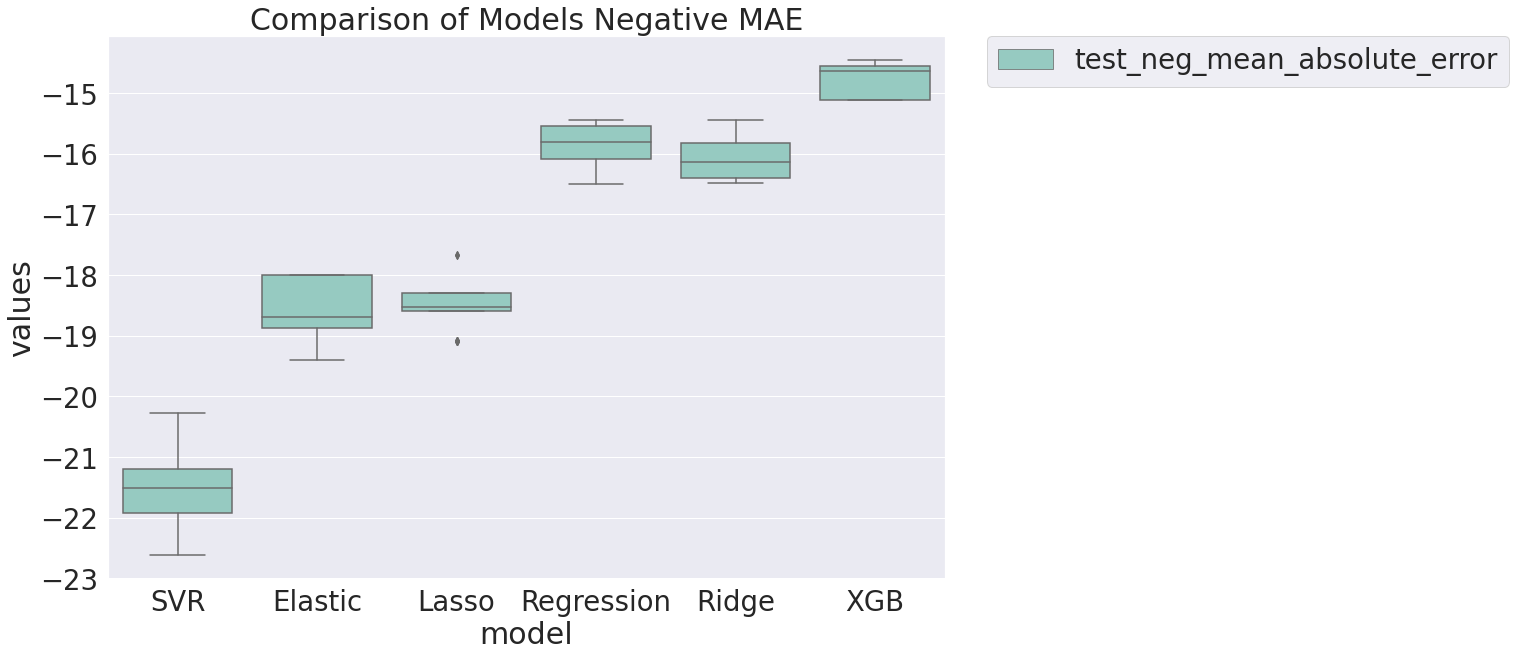

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# To plot the negative mean absolute error in a box plot

plt.figure(figsize=(15, 10))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit[results_long_nofit['metrics']=='test_neg_mean_absolute_error'], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models Negative MAE')
plt.savefig('./MAE_models_performance.png',dpi=300)

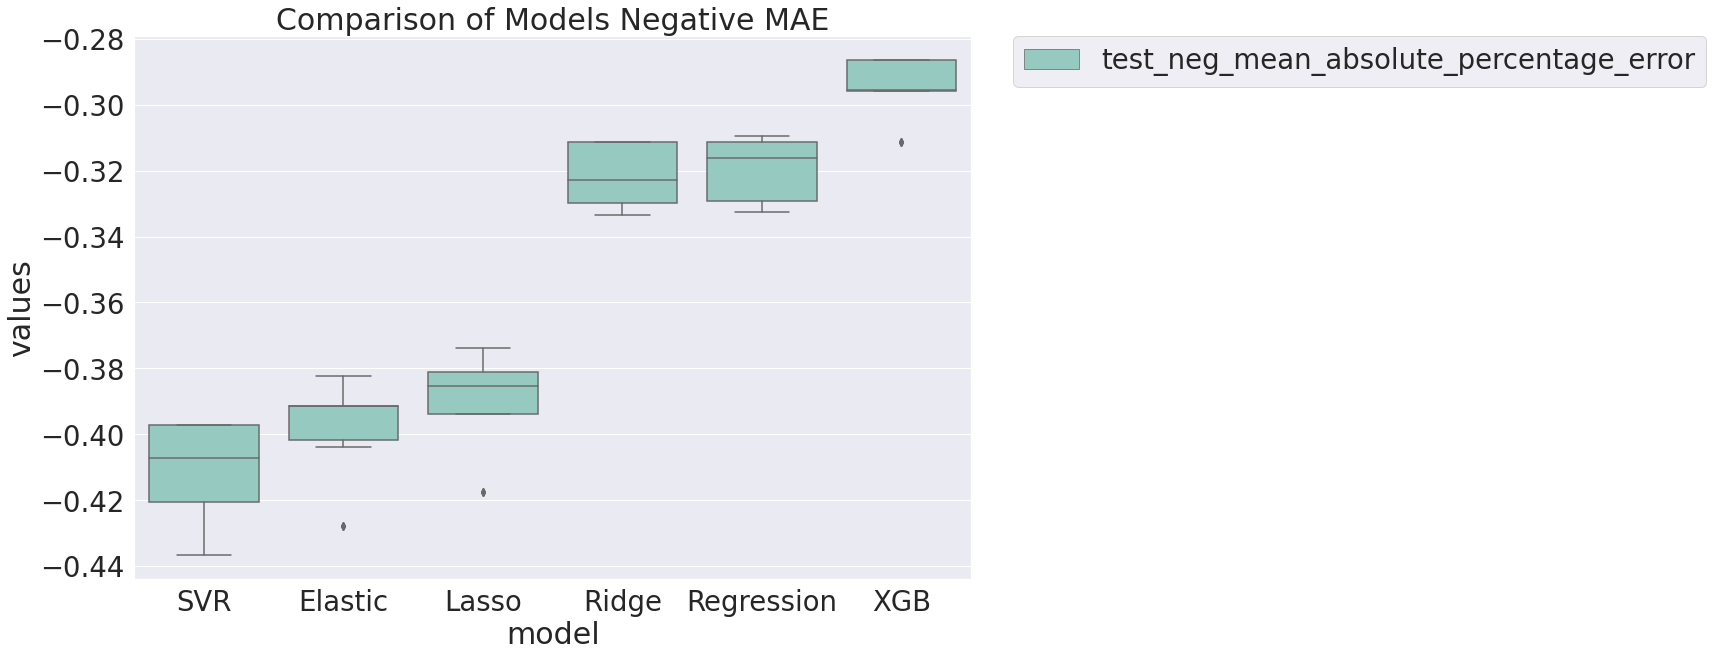

In [46]:
# To plot the negative mean absolute persentage error in a box plot

plt.figure(figsize=(15, 10))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit[results_long_nofit['metrics']=='test_neg_mean_absolute_percentage_error'], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models Negative MAE')
plt.savefig('./MAE_models_performance.png',dpi=300)

## XGBoost regressor selected

From the box plots above we can clearly see that the XGBoost algorithm outperformes the others even without any hyperparameter tuning. Therefore we select to proceed using that one


## Model hyper parameter tuning


In [47]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv(data_path + '/listings.csv')
data = data.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'name','description', 'picture_url', 'host_url', 'host_name', 
                         'host_location','host_thumbnail_url','host_picture_url','host_neighbourhood', 'neighbourhood', 'host_total_listings_count',
                         'calendar_updated','bathrooms', 'first_review','last_review', 'calendar_last_scraped',
                         'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                         'calculated_host_listings_count_shared_rooms','host_acceptance_rate', 'neighbourhood_group_cleansed', 'neighborhood_overview','beds', 
                          'bedrooms' ,'host_has_profile_pic' ,'availability_60','availability_90', 'number_of_reviews_ltm','number_of_reviews_l30d', 
                          'host_listings_count','host_identity_verified','host_since', 'host_id', 'id', 'reviews_per_month'])

data_proc = preprocess(data)

X = data_proc.drop(columns = ['price'])
y = data_proc['price']

transformerVectoriser = ColumnTransformer(
    transformers=[
        ('neighbourhood_cleansed', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed']),
        ('property_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['property_type']),
        ('room_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['room_type']),
        ('neighbourhood_cleansed_group', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed_group']),
        ('host_response_time', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_time']),
        ('host_response_rate', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_rate'])
    ], remainder='passthrough')

X_enc = transformerVectoriser.fit_transform(X)

param_grid = {
    "learning_rate": [0.032, 0.033, 0.034],
    "max_depth": [4, 5, 6],
    "n_estimators": [2000, 3000]
}

model = xg.XGBRegressor(gamma=0.1, reg_lambda=2,  colsample_bytree=0.8, subsample=0.6)
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=42)
search = RandomizedSearchCV(model, param_grid, n_iter=50, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_enc, y)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


[09:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -13.267772945508362
Best Hyperparameters: {'n_estimators': 2000, 'max_depth': 6, 'learning_rate': 0.034}


### To do cross validation

In [53]:
# Cross validation

import numpy as np
from matplotlib import pyplot
import xgboost as xg
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder


data = pd.read_csv(data_path + '/listings.csv')
data = data.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'name','description', 'picture_url', 'host_url', 'host_name', 
                         'host_location','host_thumbnail_url','host_picture_url','host_neighbourhood', 'neighbourhood', 'host_total_listings_count',
                         'calendar_updated','bathrooms', 'first_review','last_review', 'calendar_last_scraped',
                         'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                         'calculated_host_listings_count_shared_rooms','host_acceptance_rate', 'neighbourhood_group_cleansed', 'neighborhood_overview','beds', 
                          'bedrooms' ,'host_has_profile_pic' ,'availability_60','availability_90', 'number_of_reviews_ltm','number_of_reviews_l30d', 
                          'host_listings_count','host_identity_verified','host_since', 'host_id', 'id', 'reviews_per_month'])

data_proc = preprocess(data)

X = data_proc.drop(columns = ['price'])
transformerVectoriser = ColumnTransformer(
    transformers=[
        ('neighbourhood_cleansed', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed']),
        ('property_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['property_type']),
        ('room_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['room_type']),
        ('neighbourhood_cleansed_group', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed_group']),
        ('host_response_time', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_time']),
        ('host_response_rate', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_rate'])
    ], remainder='passthrough')

X_enc = transformerVectoriser.fit_transform(X)

y = data_proc['price']

model = xg.XGBRegressor(gamma=0.1, reg_lambda=2, n_estimators=2000, max_depth=6, learning_rate=0.034, colsample_bytree=0.8, subsample=0.6) 


scoring = ['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error']
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
scores = cross_validate(model, X_enc, y, scoring=scoring, cv=cv)
print(scores)
for i in sorted(scores.keys()):
    print("{}:{}, ({})".format(i, scores[i].mean(), scores[i].std()))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


[11:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## Save model in pickle file
Code used for training and saving the model in pickle file. Later to be used in the back end for price inference

In [49]:
## TO test if pipeline works
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot
import xgboost as xg
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv(data_path + '/listings.csv')
data = data.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'name','description', 'picture_url', 'host_url', 'host_name', 
                         'host_location','host_thumbnail_url','host_picture_url','host_neighbourhood', 'neighbourhood', 'host_total_listings_count',
                         'calendar_updated','bathrooms', 'first_review','last_review', 'calendar_last_scraped',
                         'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                         'calculated_host_listings_count_shared_rooms','host_acceptance_rate', 'neighbourhood_group_cleansed', 'neighborhood_overview','beds', 
                          'bedrooms' ,'host_has_profile_pic' ,'availability_60','availability_90', 'number_of_reviews_ltm','number_of_reviews_l30d', 
                          'host_listings_count','host_identity_verified','host_since', 'host_id', 'id', 'reviews_per_month'])

data_proc = preprocess(data)

X = data_proc.drop(columns = ['price'])
y = data_proc['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

## The transformer vectoriser takes the columns we want (the non numerical ones) and one hot encodes them. It does the same as pd.get_dummies but is able to be added in the pipeline 
transformerVectoriser = ColumnTransformer(
    transformers=[
        ('neighbourhood_cleansed', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed']),
        ('property_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['property_type']),
        ('room_type', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['room_type']),
        ('neighbourhood_cleansed_group', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['neighbourhood_cleansed_group']),
        ('host_response_time', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_time']),
        ('host_response_rate', OneHotEncoder(sparse=True, handle_unknown='ignore'), ['host_response_rate'])
    ], remainder='passthrough')

# create the pipeline. It has two components, the vectorizer that one hot encodes the non-numerical features and the xgboost regressor
reg = Pipeline([('enc', transformerVectoriser),
                ('reg', xg.XGBRegressor(gamma=0.1, reg_lambda=2, n_estimators=2000, max_depth=6, learning_rate=0.034, colsample_bytree=0.8, subsample=0.6))])

reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(" ")
print("###### Results with the trained pipeline")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Percentage Error', metrics.mean_absolute_percentage_error(y_test,y_pred))
print('#########')  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


joblib.dump(reg, data_path + 'pipeline.pkl') # Save pipeline in a pickle file

loaded_reg = joblib.load(data_path + 'pipeline.pkl') # Load pipeline in a new variable
y_pred_load = loaded_reg.predict(X_test) # use this pipeline for prediction

print(" ")
print("###### Results with the reloaded pipeline - To verify results are the same")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_load))
print('Mean Absolute Percentage Error', metrics.mean_absolute_percentage_error(y_test, y_pred_load))
print('#########')  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_load))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_load)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


[10:24:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 
###### Results with the trained pipeline
Mean Absolute Error: 12.657767044603824
Mean Absolute Percentage Error 0.24568987697487668
#########
Mean Squared Error: 329.23401751029184
Root Mean Squared Error: 18.144806901984154
[10:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 
###### Results with the reloaded pipeline - To verify results are the same
Mean Absolute Error: 12.657767044603824
Mean Absolute Percentage Error 0.24568987697487668
#########
Mean Squared Error: 329.23401751029184
Root Mean Squared Error: 18.144806901984154
